# Test Segementer Paremeters

The goal of this ipython notebook is to test different parameters of the segmenter
   

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import json
import numpy as np
import copy
from datetime import datetime, timedelta
import os
plt.style.use('bmh')

In [160]:
def map_segment(filename, noise_dist=0, max_speed=30, max_speed_exponent=1.3, max_speed_multiplier=15):
    newfilename = filename.replace(".json","-new.json")
    command = "gpsdio segment --max-speed={max_speed} --noise-dist={noise_dist}  \
    --max-speed-multiplier={max_speed_multiplier} --max-speed-exponent={max_speed_exponent}\
    '{filename}' '{newfilename}'".format(max_speed=max_speed, 
                                         noise_dist=noise_dist, 
                                         filename=filename, 
                                         newfilename=newfilename, 
                                         max_speed_multiplier=max_speed_multiplier,
                                         max_speed_exponent=max_speed_exponent)
    
    print command
    os.system(command)
    
    with open(newfilename, "rU") as f:
        x = '[%s]' % ','.join(f.readlines())
    
    x = json.loads(x)    
    dfv = pd.DataFrame.from_dict(x)
    dfv = dfv.sort_values(['segment','timestamp'])

    
    xx = []
    yy = []
    x = []
    y = []
    segment = dfv.iloc[0].segment
    mmsi = dfv.iloc[0].mmsi
    start = dfv.iloc[0].timestamp
    end = dfv.iloc[-1].timestamp

    for ix, row in dfv.iterrows():
        if row.segment == segment:
            x.append(row.lon)
            y.append(row.lat)
        else:
            xx.append(x)
            yy.append(y)
            x = []
            y = []
            segment = row.segment
            x.append(row.lon)
            y.append(row.lat) 
    xx.append(x)
    yy.append(y)
    cols = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
    for i, (x,y) in enumerate(zip(xx,yy)):
        plt.scatter(x,y, color=cols[i%len(cols)])
        
    start = start[:10]
    end = end[:10]
    num_segs = len(xx)
    title = "{mmsi} from {start} to {end}\n\
    noise-dist={noise_dist}, max-speed={max_speed}, # segments = {num_segs}\n\
    max-speed-multiplier={max_speed_multiplier}, max_speed_exponent={max_speed_exponent}".format(start=start,
                                                        end=end, 
                                                        mmsi=mmsi, noise_dist=noise_dist,
                                                        max_speed=max_speed,
                                                        num_segs = num_segs,
                                                        max_speed_exponent=max_speed_exponent,
                                                        max_speed_multiplier=max_speed_multiplier)
    plt.title(title)
    plt.show()


In [135]:
# First step: identify some questionable segments

q = '''SELECT
  mmsi,
  a.seg_id seg_id,
  a.next_seg_id next_seg_id,
  avg_dist_nm,
  jumps,
  seg_point_count,
  next_seg_point_count,
  seg_first_timestamp,
  next_seg_first_timestamp, 
  seg_last_timestamp,
  next_seg_last_timestamp
FROM (
  SELECT
    mmsi,
    seg_id,
    next_seg_id,
    AVG(dist_nm) avg_dist_nm,
    COUNT(*) jumps
  FROM (
    SELECT
      *,
      dist_nm/tot_hours knots
    FROM (
      SELECT
        mmsi,
        (next_timestamp - timestamp)/3600000000 tot_hours,
        (ACOS(COS(RADIANS(90-lat)) *COS(RADIANS(90-next_lat)) +SIN(RADIANS(90-lat)) *SIN(RADIANS(90-next_lat)) * COS(RADIANS(lon-next_lon)))*6371000)/1000/1.852 dist_nm,
        seg_id,
        next_seg_id,
        timestamp,
        next_timestamp,
        lat,
        lon
      FROM (
        SELECT
          mmsi,
          seg_id,
          LEAD(timestamp,1) OVER (PARTITION BY mmsi ORDER BY timestamp) next_timestamp,
          LEAD(seg_id,1) OVER (PARTITION BY mmsi ORDER BY timestamp) next_seg_id,
          LEAD(timestamp,1) OVER (PARTITION BY seg_id ORDER BY timestamp) next_timestamp_seg,
          timestamp,
          lat,
          lon,
          LEAD(lat,1) OVER (PARTITION BY mmsi ORDER BY timestamp) next_lat,
          LEAD(lon,1) OVER (PARTITION BY mmsi ORDER BY timestamp) next_lon
        FROM
          [world-fishing-827:scratch_paul.pipe_segment_v0_9_alpha_2015_01]
        WHERE
          lat IS NOT NULL
          AND lon IS NOT NULL))
    WHERE
      tot_hours < 24)
  WHERE
    next_seg_id IS NOT NULL
  GROUP BY
    seg_id,
    next_seg_id,
    mmsi) a
INNER JOIN (
  SELECT
    x.seg_id seg_id,
    y.seg_id next_seg_id,
    x.point_count seg_point_count,
    y.point_count next_seg_point_count,
    x.first_timestamp seg_first_timestamp,
    y.first_timestamp next_seg_first_timestamp,
    x.last_timestamp seg_last_timestamp,
    y.last_timestamp next_seg_last_timestamp
  FROM
    [world-fishing-827:scratch_david_seg_analysis.segs_v0_9_alpha_2015_01] x
  LEFT JOIN
    [world-fishing-827:scratch_david_seg_analysis.segs_v0_9_alpha_2015_01] y
  ON
    x.mmsi = y.mmsi
  WHERE
    x.first_timestamp < y.last_timestamp
    AND x.last_timestamp > y.first_timestamp
    AND x.seg_id != y.seg_id
    -- and a.max_lat > b.min_lat and a.min_lat < b.max_lat
    -- and a.max_lon > b.min_lon and a.min_lon < b.min_lon
    ) b
ON
  a.seg_id = b.seg_id
  AND a.next_seg_id = b.next_seg_id
  where seg_point_count > 100
  and next_seg_point_count > 100
  and avg_dist_nm < 50'''

df = pd.io.gbq.read_gbq(q, project_id='world-fishing-827',verbose=False)
print len(df)
df.head()

988


mmsi                                 seg_id  \
0  412704010  412704010-2015-01-02T04:32:08.000000Z   
1  412423672  412423672-2015-01-03T00:05:15.000000Z   
2  413424240  413424240-2015-01-19T05:17:11.000000Z   
3  245250000  245250000-2015-01-21T16:19:22.000000Z   
4  414744000  414744000-2015-01-03T16:33:57.000000Z   

                             next_seg_id  avg_dist_nm  jumps  seg_point_count  \
0  412704010-2015-01-01T00:12:52.000000Z     7.057268      2              455   
1  412423672-2015-01-03T19:06:06.000000Z    36.805684     17              119   
2  413424240-2015-01-01T03:55:55.000000Z     9.628033    199              423   
3  245250000-2015-01-01T00:04:57.000000Z    42.744639      3              700   
4  414744000-2015-01-01T00:01:54.000000Z    10.089516      6              982   

   next_seg_point_count seg_first_timestamp next_seg_first_timestamp  \
0                   160 2015-01-02 04:32:08      2015-01-01 00:12:52   
1                   829 2015-01-03 00:05:15      2015-01-03 19:06:06   
2                  3425 2015-01-19 05:17:11      2015-01-01 03:55:55   
3                  1899 2015-01-21 16:19:22      2015-01-01 00:04:57   
4                   400 2015-01-03 16:33:57      2015-01-01 00:04:47   

   seg_last_timestamp next_seg_last_timestamp  
0 2015-01-10 03:19:30     2015-01-02 21:43:49  
1 2015-01-04 21:13:34     2015-01-15 01:21:37  
2 2015-02-01 23:46:50     2015-02-01 23:58:51  
3 2015-01-31 19:26:46     2015-01-22 02:06:22  
4 2015-01-16 21:04:22     2015-01-05 00:51:04

In [20]:
def get_timerange(row):
    start = max(row.seg_first_timestamp, row.next_seg_first_timestamp)
    end = min(row.seg_last_timestamp, row.next_seg_last_timestamp)
    start = start + timedelta(days=-.5)
    end = end + timedelta(days=.5)
    return start, end

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=24 --max-speed-exponent=1    '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49.json' '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49-new.json'


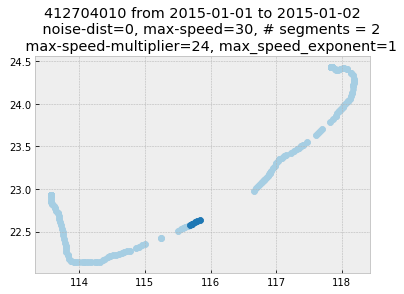

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=24 --max-speed-exponent=1    '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49.json' '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49-new.json'


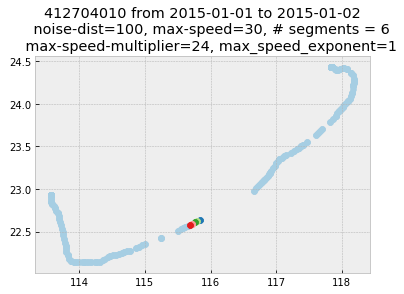

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=24 --max-speed-exponent=1    '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49.json' '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49-new.json'


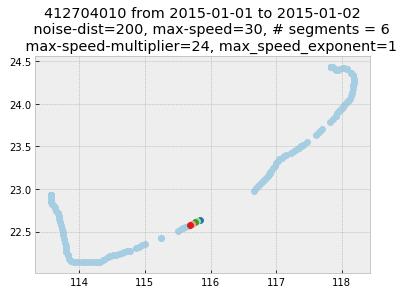

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=40 --max-speed-exponent=1    '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49.json' '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49-new.json'


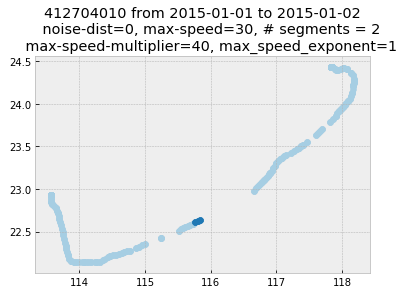

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=40 --max-speed-exponent=1    '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49.json' '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49-new.json'


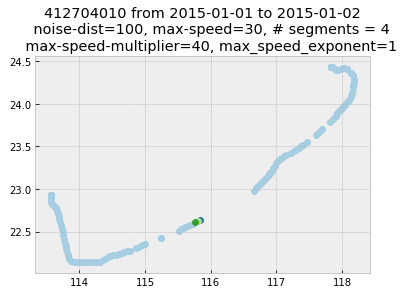

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=40 --max-speed-exponent=1    '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49.json' '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49-new.json'


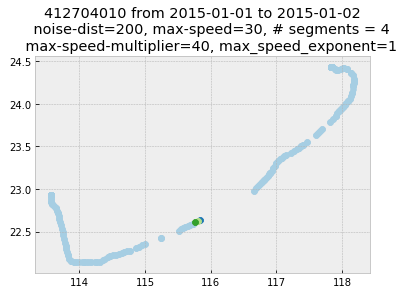

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=15 --max-speed-exponent=1.3    '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49.json' '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49-new.json'


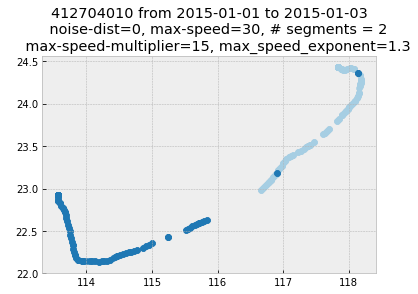

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=15 --max-speed-exponent=1.3    '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49.json' '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49-new.json'


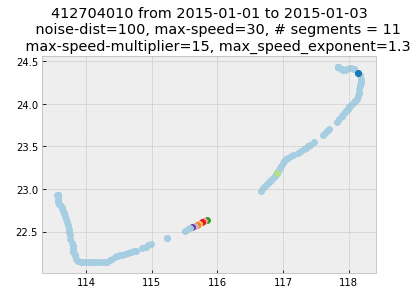

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=15 --max-speed-exponent=1.3    '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49.json' '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49-new.json'


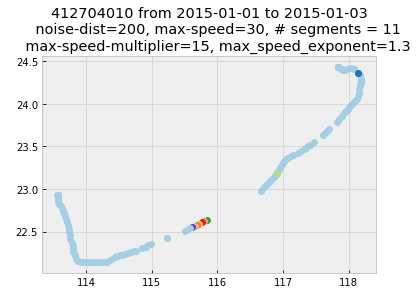

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=1600 --max-speed-exponent=2    '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49.json' '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49-new.json'


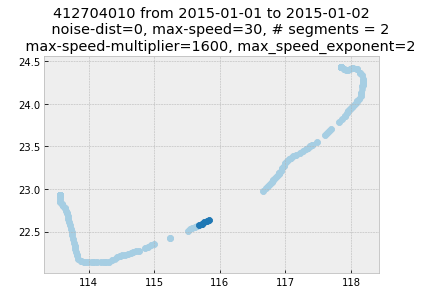

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=1600 --max-speed-exponent=2    '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49.json' '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49-new.json'


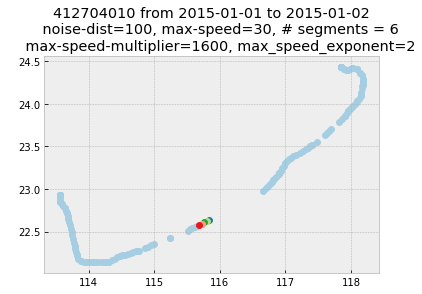

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=1600 --max-speed-exponent=2    '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49.json' '412704010-2015-01-01 16:32:08-2015-01-03 09:43:49-new.json'


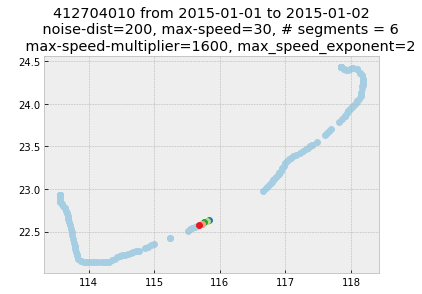

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=24 --max-speed-exponent=1    '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34.json' '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34-new.json'


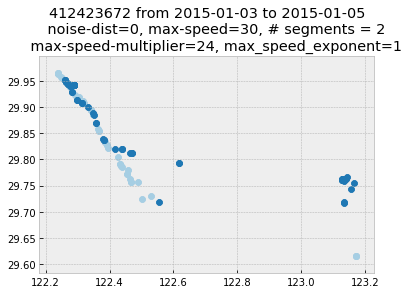

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=24 --max-speed-exponent=1    '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34.json' '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34-new.json'


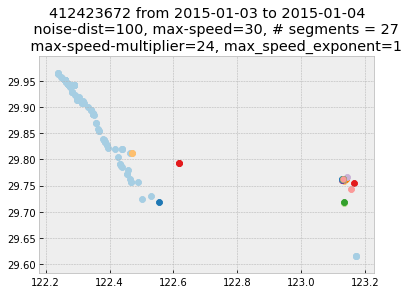

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=24 --max-speed-exponent=1    '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34.json' '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34-new.json'


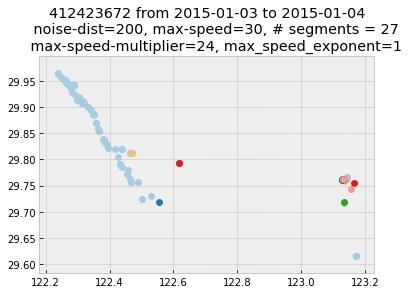

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=40 --max-speed-exponent=1    '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34.json' '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34-new.json'


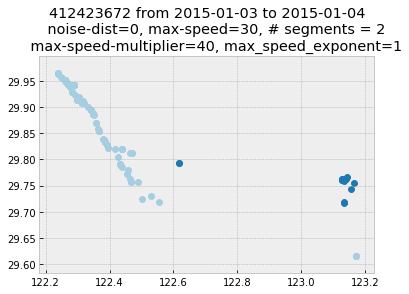

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=40 --max-speed-exponent=1    '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34.json' '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34-new.json'


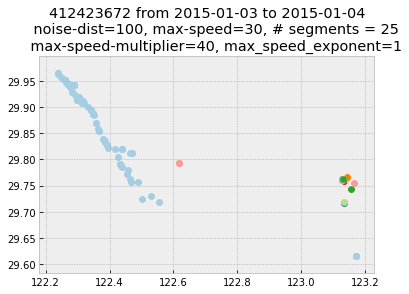

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=40 --max-speed-exponent=1    '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34.json' '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34-new.json'


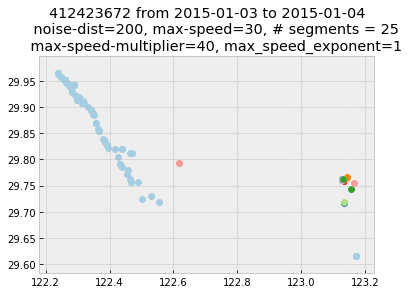

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=15 --max-speed-exponent=1.3    '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34.json' '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34-new.json'


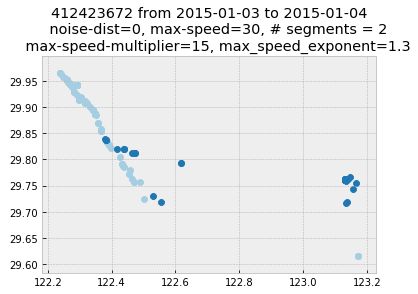

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=15 --max-speed-exponent=1.3    '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34.json' '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34-new.json'


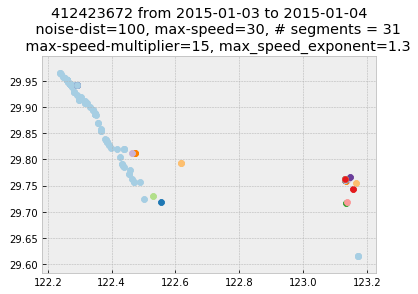

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=15 --max-speed-exponent=1.3    '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34.json' '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34-new.json'


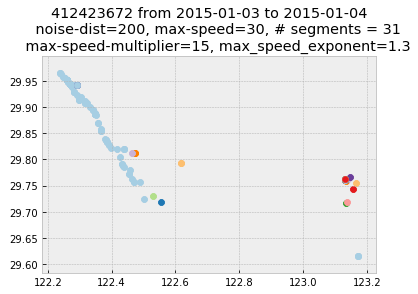

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=1600 --max-speed-exponent=2    '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34.json' '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34-new.json'


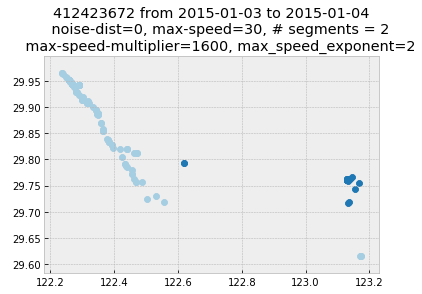

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=1600 --max-speed-exponent=2    '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34.json' '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34-new.json'


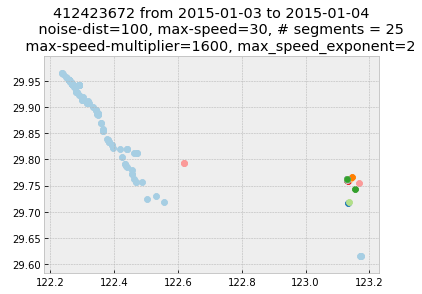

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=1600 --max-speed-exponent=2    '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34.json' '412423672-2015-01-03 07:06:06-2015-01-05 09:13:34-new.json'


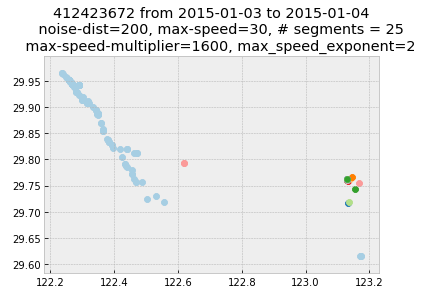

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=24 --max-speed-exponent=1    '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50.json' '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50-new.json'


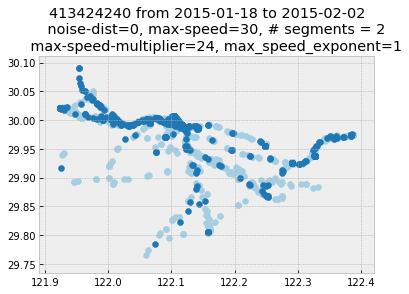

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=24 --max-speed-exponent=1    '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50.json' '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50-new.json'


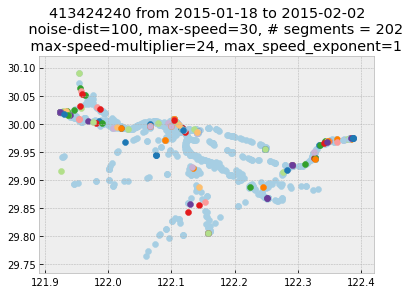

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=24 --max-speed-exponent=1    '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50.json' '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50-new.json'


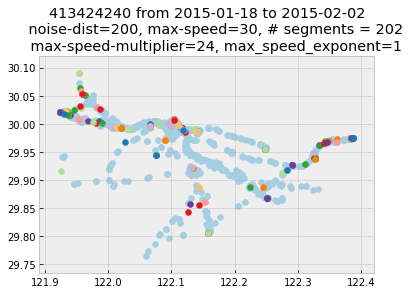

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=40 --max-speed-exponent=1    '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50.json' '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50-new.json'


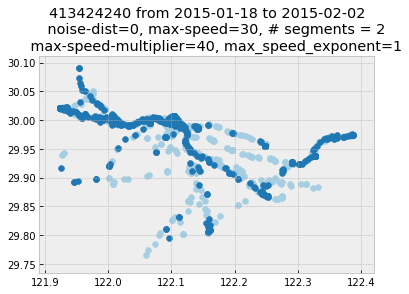

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=40 --max-speed-exponent=1    '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50.json' '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50-new.json'


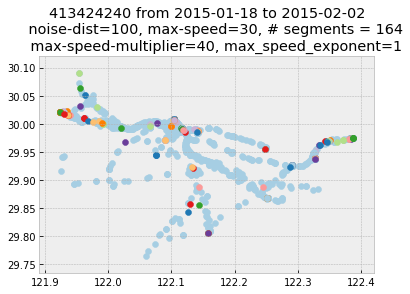

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=40 --max-speed-exponent=1    '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50.json' '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50-new.json'


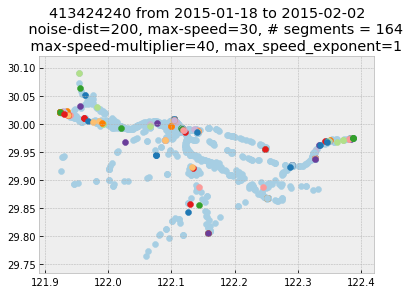

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=15 --max-speed-exponent=1.3    '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50.json' '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50-new.json'


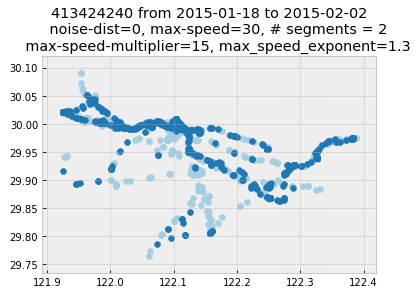

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=15 --max-speed-exponent=1.3    '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50.json' '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50-new.json'


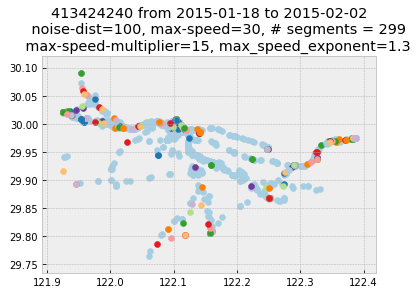

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=15 --max-speed-exponent=1.3    '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50.json' '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50-new.json'


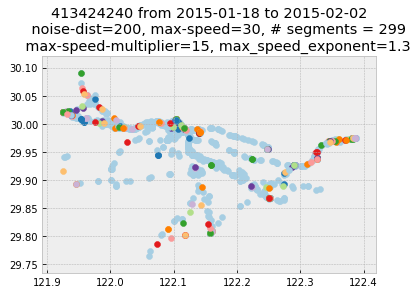

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=1600 --max-speed-exponent=2    '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50.json' '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50-new.json'


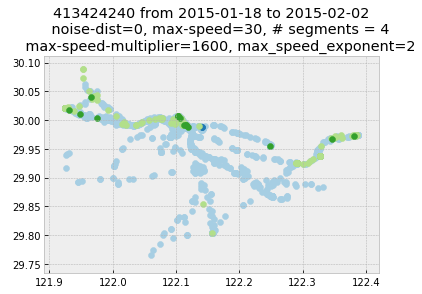

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=1600 --max-speed-exponent=2    '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50.json' '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50-new.json'


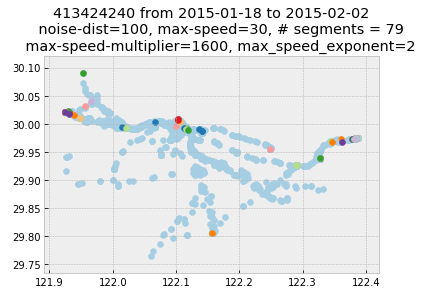

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=1600 --max-speed-exponent=2    '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50.json' '413424240-2015-01-18 17:17:11-2015-02-02 11:46:50-new.json'


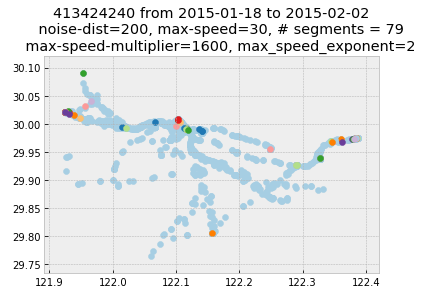

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=24 --max-speed-exponent=1    '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22.json' '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22-new.json'


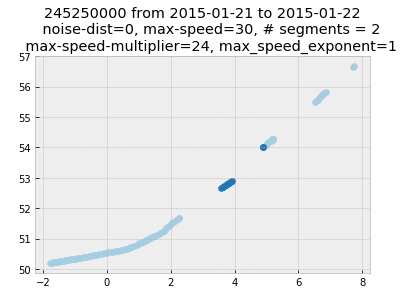

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=24 --max-speed-exponent=1    '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22.json' '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22-new.json'


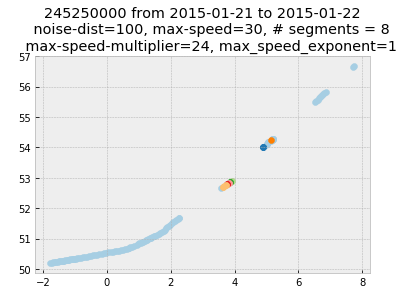

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=24 --max-speed-exponent=1    '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22.json' '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22-new.json'


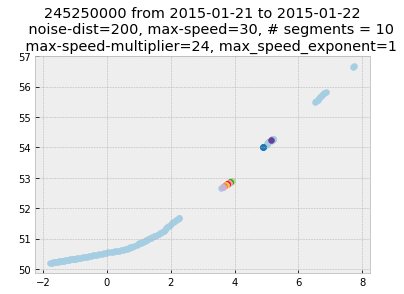

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=40 --max-speed-exponent=1    '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22.json' '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22-new.json'


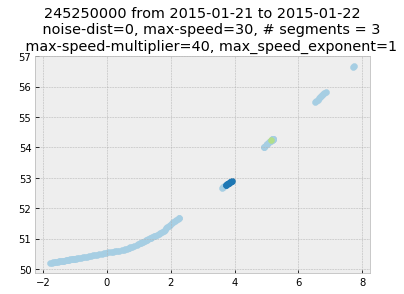

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=40 --max-speed-exponent=1    '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22.json' '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22-new.json'


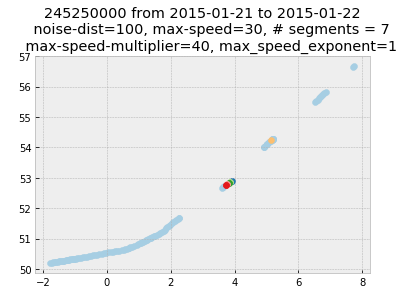

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=40 --max-speed-exponent=1    '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22.json' '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22-new.json'


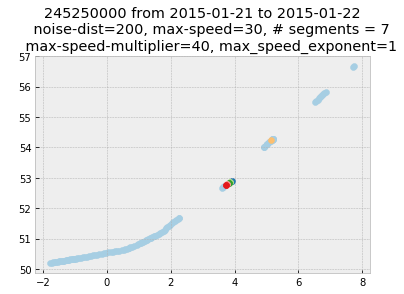

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=15 --max-speed-exponent=1.3    '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22.json' '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22-new.json'


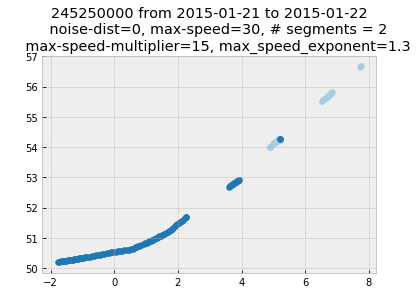

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=15 --max-speed-exponent=1.3    '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22.json' '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22-new.json'


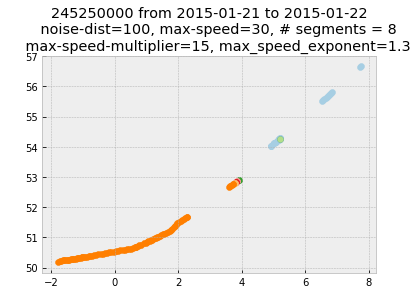

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=15 --max-speed-exponent=1.3    '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22.json' '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22-new.json'


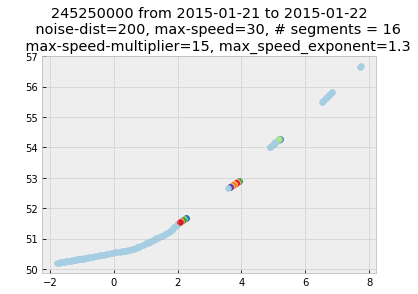

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=1600 --max-speed-exponent=2    '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22.json' '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22-new.json'


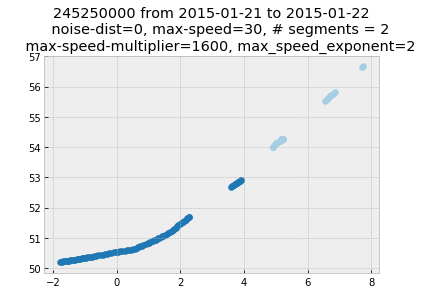

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=1600 --max-speed-exponent=2    '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22.json' '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22-new.json'


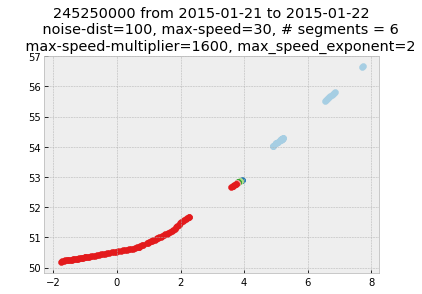

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=1600 --max-speed-exponent=2    '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22.json' '245250000-2015-01-21 04:19:22-2015-01-22 14:06:22-new.json'


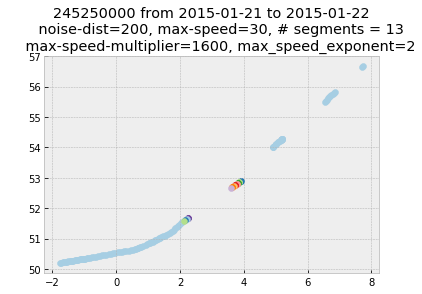

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=24 --max-speed-exponent=1    '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04.json' '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04-new.json'


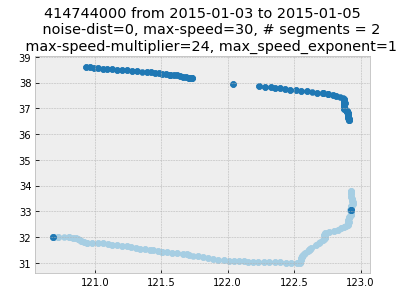

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=24 --max-speed-exponent=1    '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04.json' '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04-new.json'


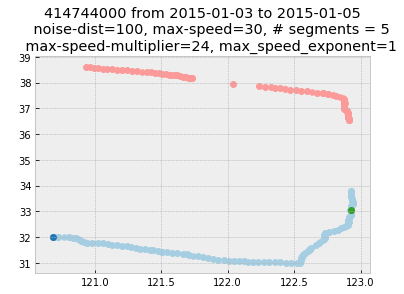

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=24 --max-speed-exponent=1    '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04.json' '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04-new.json'


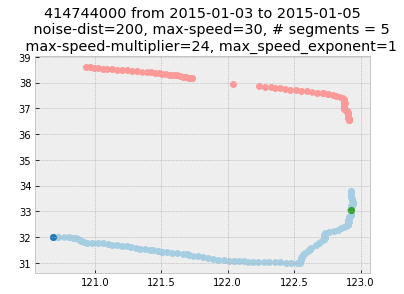

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=40 --max-speed-exponent=1    '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04.json' '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04-new.json'


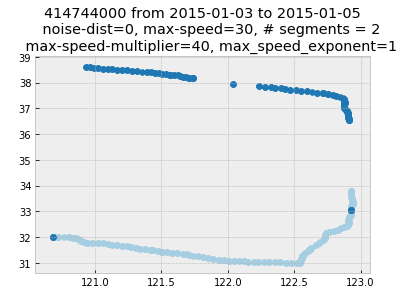

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=40 --max-speed-exponent=1    '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04.json' '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04-new.json'


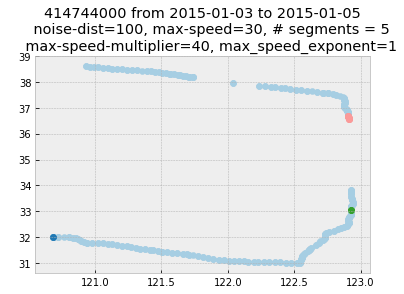

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=40 --max-speed-exponent=1    '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04.json' '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04-new.json'


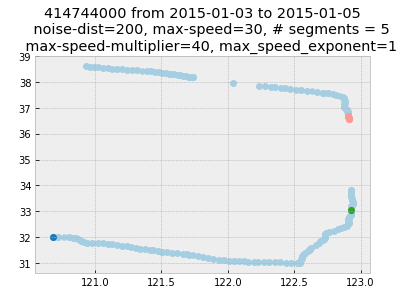

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=15 --max-speed-exponent=1.3    '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04.json' '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04-new.json'


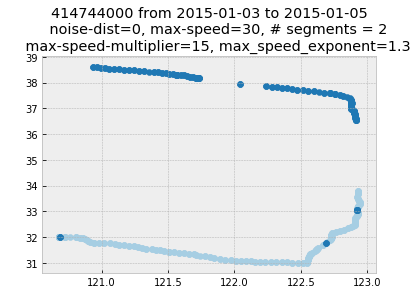

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=15 --max-speed-exponent=1.3    '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04.json' '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04-new.json'


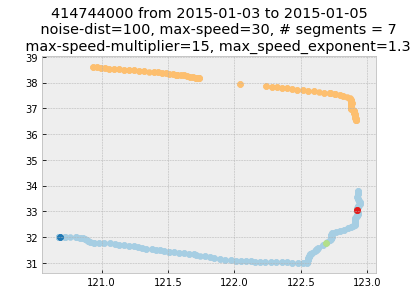

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=15 --max-speed-exponent=1.3    '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04.json' '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04-new.json'


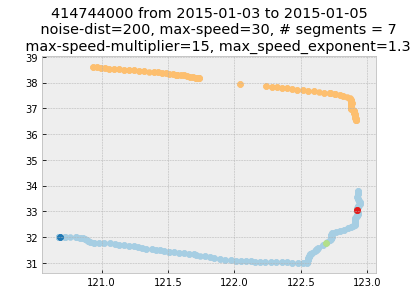

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=1600 --max-speed-exponent=2    '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04.json' '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04-new.json'


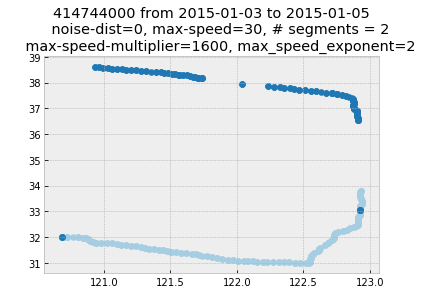

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=1600 --max-speed-exponent=2    '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04.json' '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04-new.json'


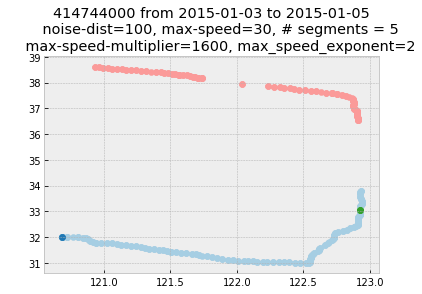

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=1600 --max-speed-exponent=2    '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04.json' '414744000-2015-01-03 04:33:57-2015-01-05 12:51:04-new.json'


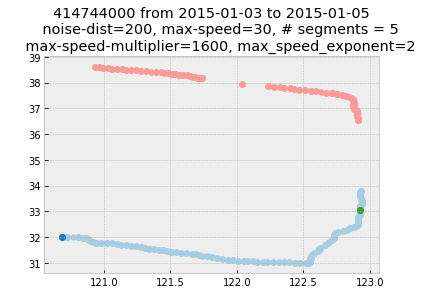

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=24 --max-speed-exponent=1    '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44.json' '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44-new.json'


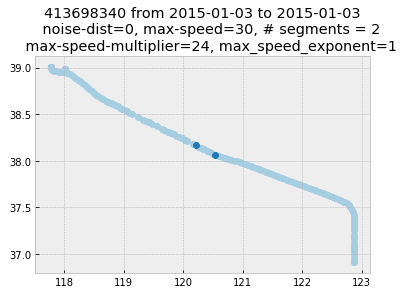

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=24 --max-speed-exponent=1    '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44.json' '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44-new.json'


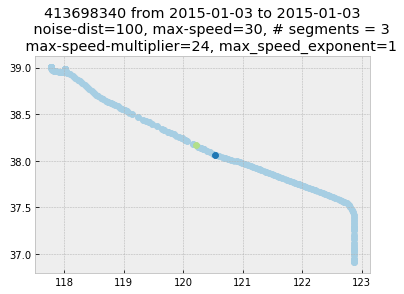

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=24 --max-speed-exponent=1    '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44.json' '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44-new.json'


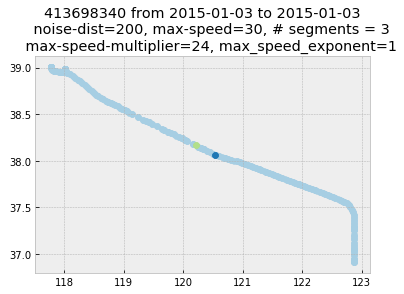

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=40 --max-speed-exponent=1    '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44.json' '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44-new.json'


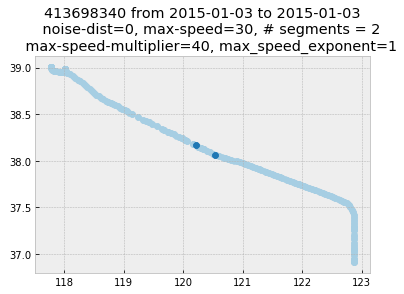

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=40 --max-speed-exponent=1    '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44.json' '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44-new.json'


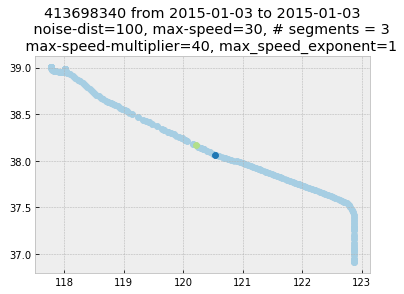

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=40 --max-speed-exponent=1    '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44.json' '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44-new.json'


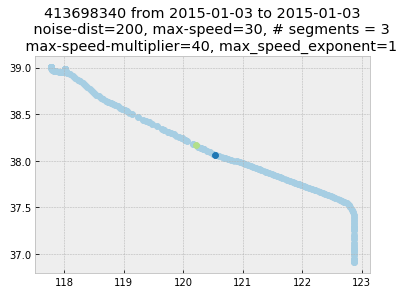

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=15 --max-speed-exponent=1.3    '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44.json' '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44-new.json'


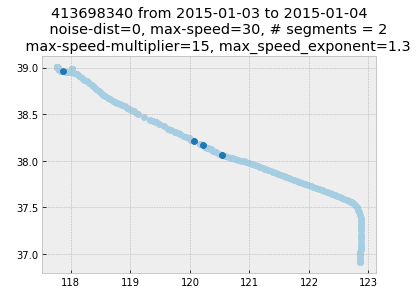

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=15 --max-speed-exponent=1.3    '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44.json' '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44-new.json'


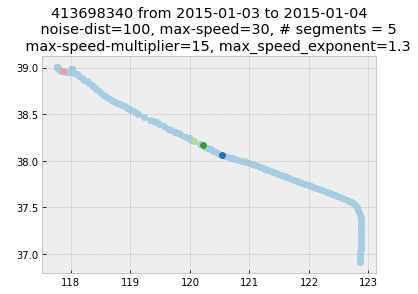

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=15 --max-speed-exponent=1.3    '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44.json' '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44-new.json'


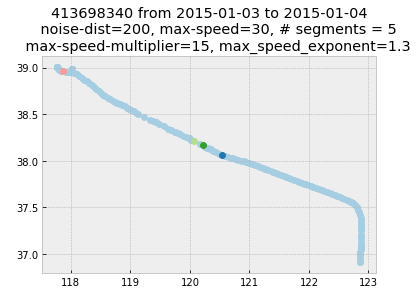

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=1600 --max-speed-exponent=2    '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44.json' '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44-new.json'


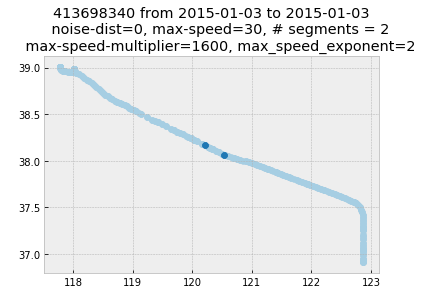

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=1600 --max-speed-exponent=2    '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44.json' '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44-new.json'


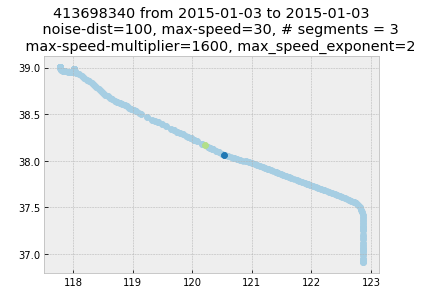

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=1600 --max-speed-exponent=2    '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44.json' '413698340-2015-01-03 02:34:14-2015-01-04 23:24:44-new.json'


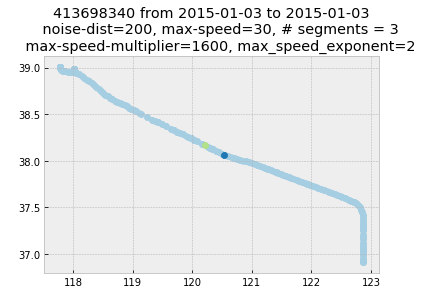

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=24 --max-speed-exponent=1    '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47.json' '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47-new.json'


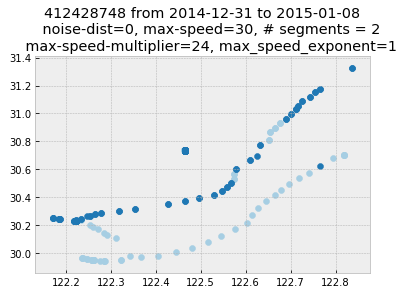

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=24 --max-speed-exponent=1    '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47.json' '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47-new.json'


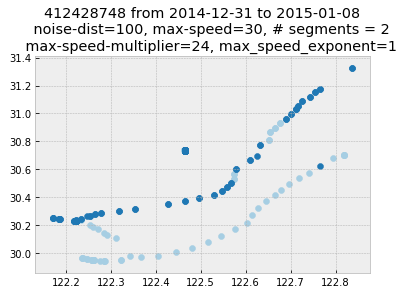

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=24 --max-speed-exponent=1    '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47.json' '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47-new.json'


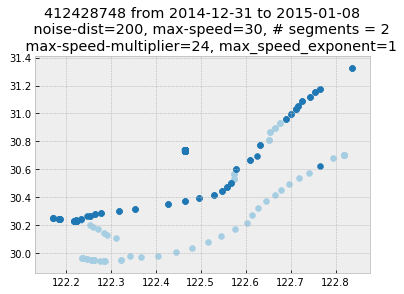

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=40 --max-speed-exponent=1    '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47.json' '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47-new.json'


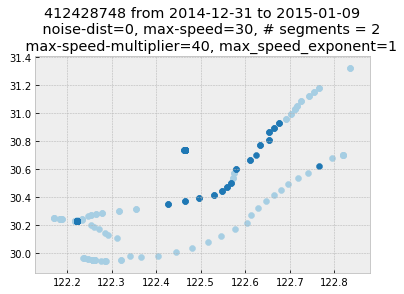

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=40 --max-speed-exponent=1    '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47.json' '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47-new.json'


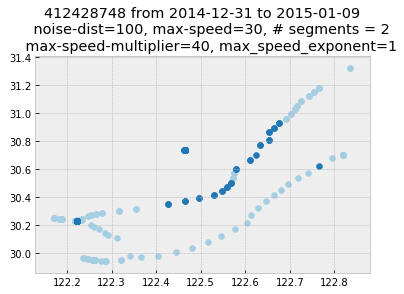

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=40 --max-speed-exponent=1    '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47.json' '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47-new.json'


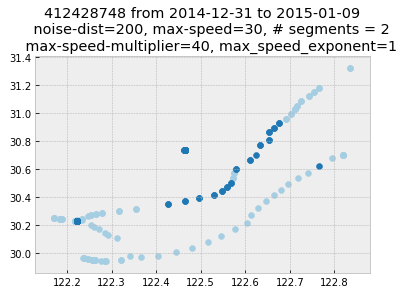

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=15 --max-speed-exponent=1.3    '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47.json' '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47-new.json'


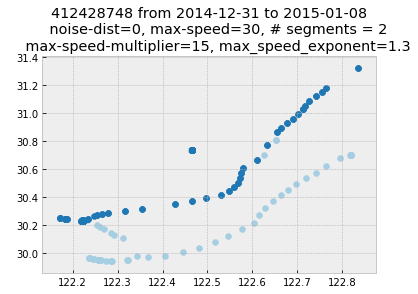

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=15 --max-speed-exponent=1.3    '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47.json' '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47-new.json'


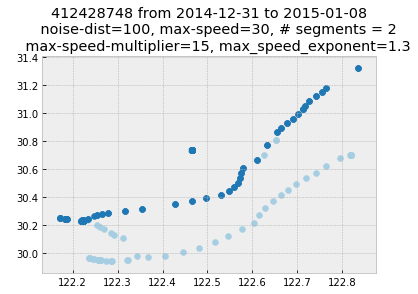

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=15 --max-speed-exponent=1.3    '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47.json' '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47-new.json'


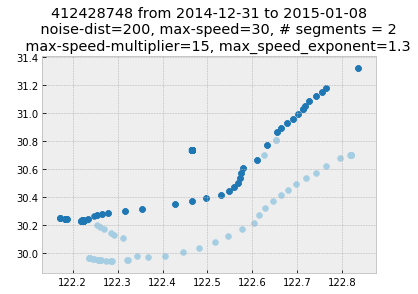

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=1600 --max-speed-exponent=2    '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47.json' '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47-new.json'


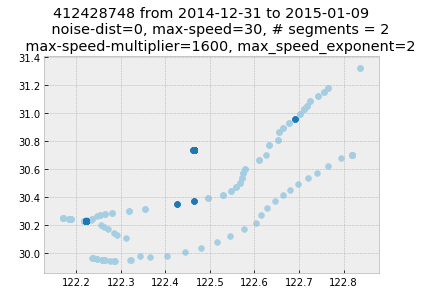

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=1600 --max-speed-exponent=2    '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47.json' '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47-new.json'


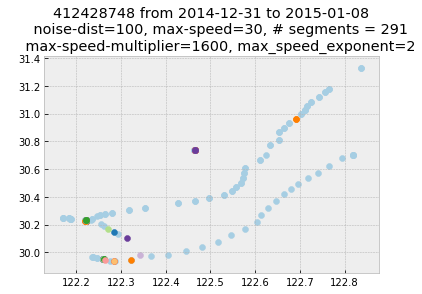

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=1600 --max-speed-exponent=2    '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47.json' '412428748-2014-12-31 21:52:14-2015-01-09 09:27:47-new.json'


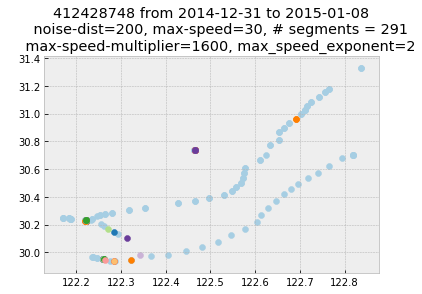

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=24 --max-speed-exponent=1    '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48.json' '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48-new.json'


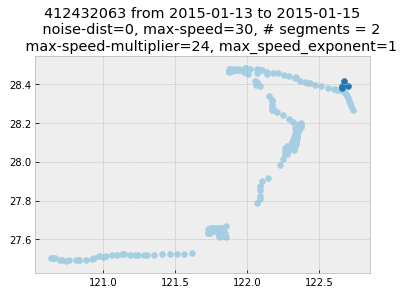

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=24 --max-speed-exponent=1    '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48.json' '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48-new.json'


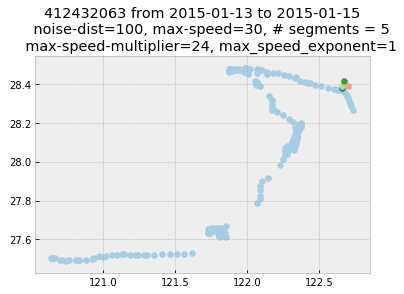

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=24 --max-speed-exponent=1    '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48.json' '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48-new.json'


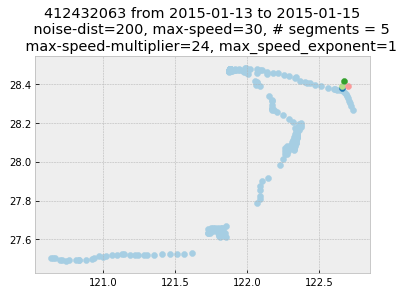

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=40 --max-speed-exponent=1    '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48.json' '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48-new.json'


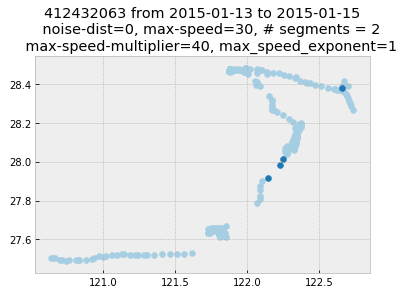

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=40 --max-speed-exponent=1    '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48.json' '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48-new.json'


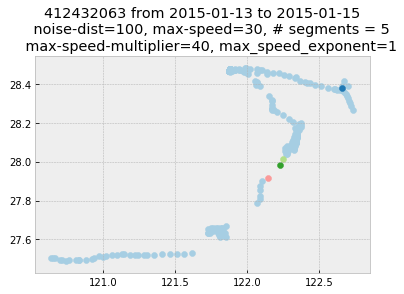

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=40 --max-speed-exponent=1    '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48.json' '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48-new.json'


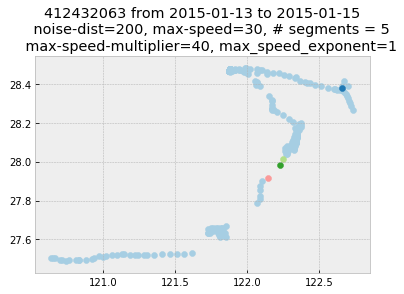

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=15 --max-speed-exponent=1.3    '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48.json' '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48-new.json'


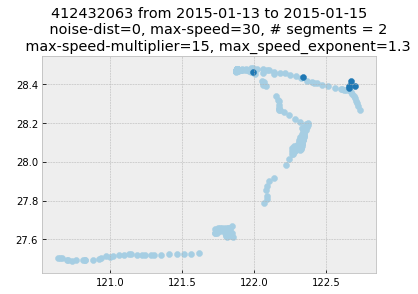

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=15 --max-speed-exponent=1.3    '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48.json' '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48-new.json'


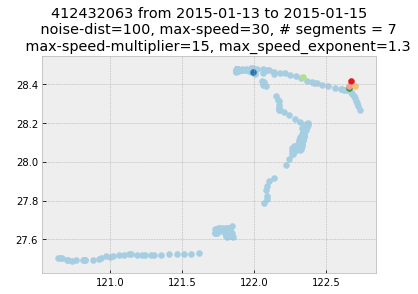

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=15 --max-speed-exponent=1.3    '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48.json' '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48-new.json'


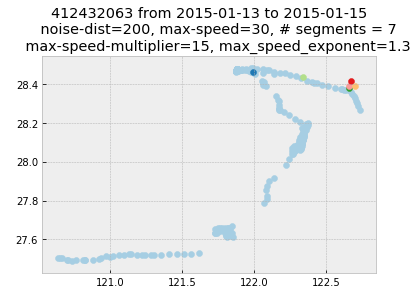

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=1600 --max-speed-exponent=2    '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48.json' '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48-new.json'


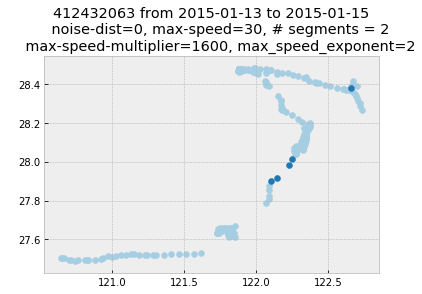

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=1600 --max-speed-exponent=2    '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48.json' '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48-new.json'


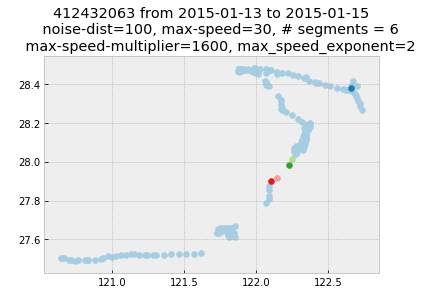

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=1600 --max-speed-exponent=2    '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48.json' '412432063-2015-01-13 01:47:30-2015-01-16 01:01:48-new.json'


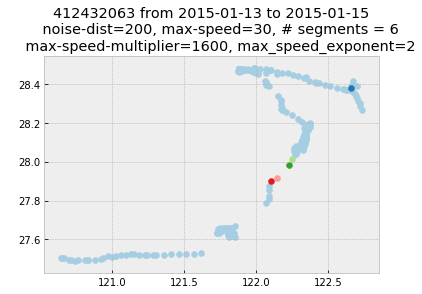

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=24 --max-speed-exponent=1    '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18.json' '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18-new.json'


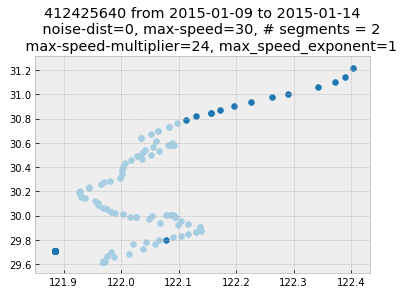

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=24 --max-speed-exponent=1    '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18.json' '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18-new.json'


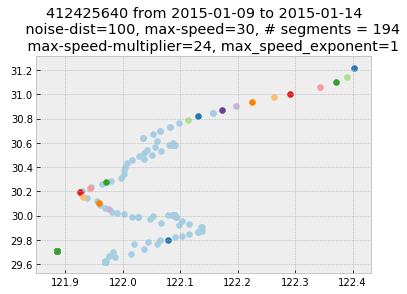

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=24 --max-speed-exponent=1    '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18.json' '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18-new.json'


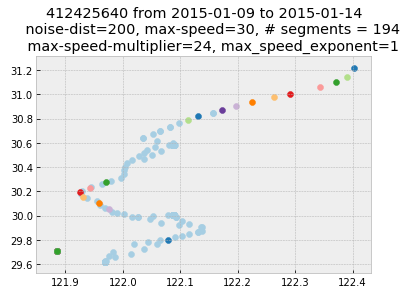

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=40 --max-speed-exponent=1    '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18.json' '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18-new.json'


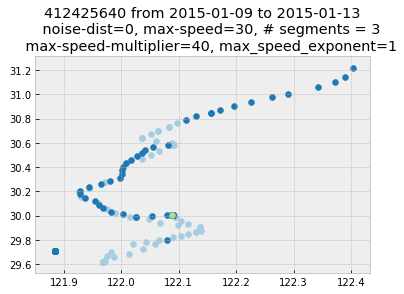

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=40 --max-speed-exponent=1    '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18.json' '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18-new.json'


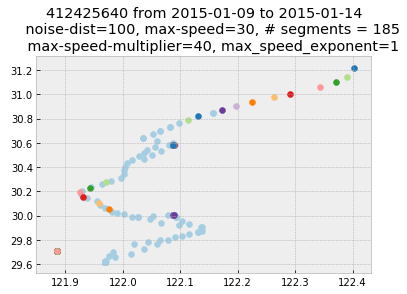

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=40 --max-speed-exponent=1    '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18.json' '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18-new.json'


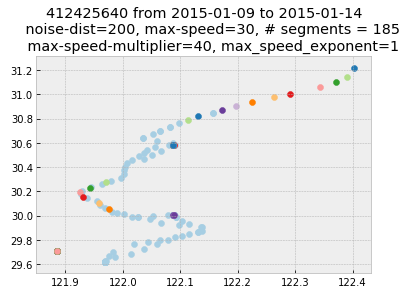

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=15 --max-speed-exponent=1.3    '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18.json' '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18-new.json'


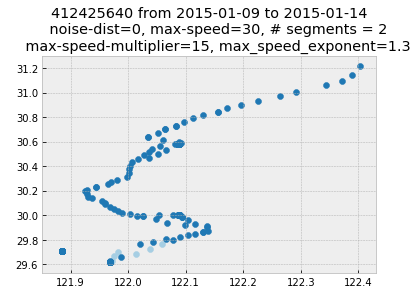

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=15 --max-speed-exponent=1.3    '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18.json' '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18-new.json'


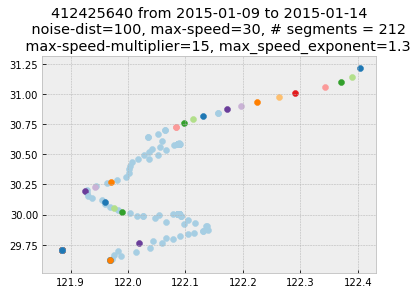

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=15 --max-speed-exponent=1.3    '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18.json' '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18-new.json'


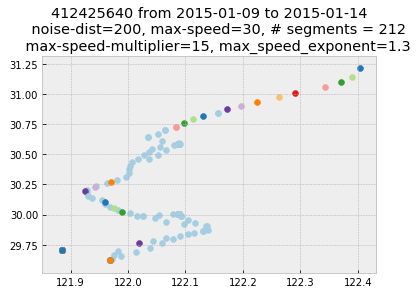

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=1600 --max-speed-exponent=2    '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18.json' '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18-new.json'


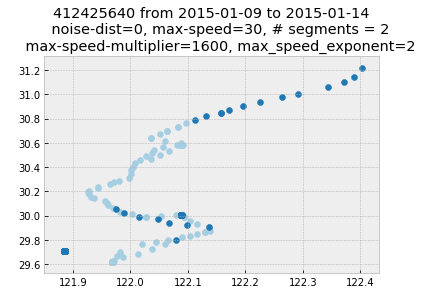

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=1600 --max-speed-exponent=2    '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18.json' '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18-new.json'


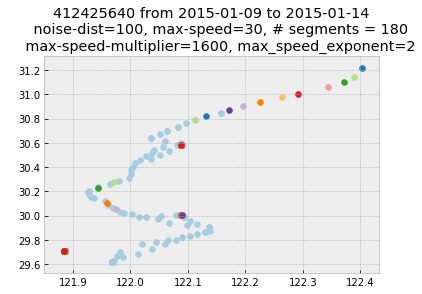

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=1600 --max-speed-exponent=2    '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18.json' '412425640-2015-01-09 13:48:15-2015-01-14 18:03:18-new.json'


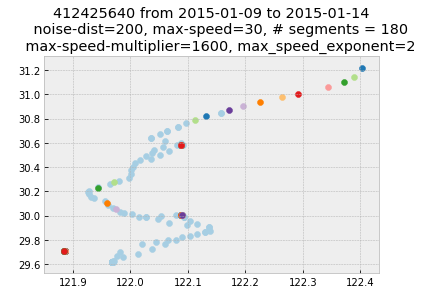

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=24 --max-speed-exponent=1    '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49.json' '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49-new.json'


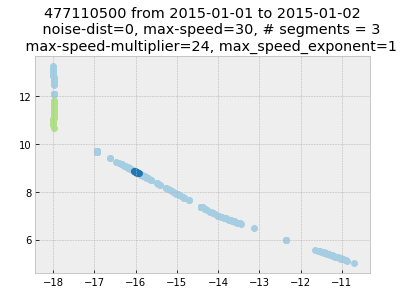

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=24 --max-speed-exponent=1    '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49.json' '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49-new.json'


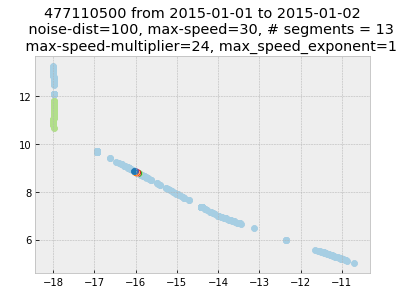

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=24 --max-speed-exponent=1    '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49.json' '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49-new.json'


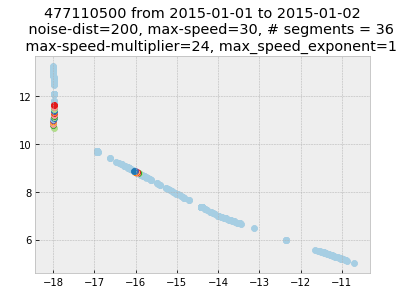

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=40 --max-speed-exponent=1    '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49.json' '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49-new.json'


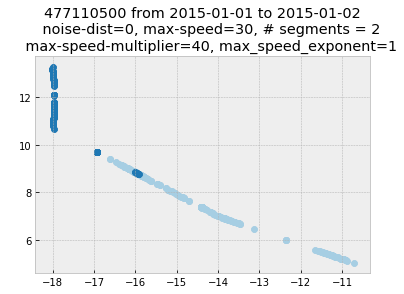

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=40 --max-speed-exponent=1    '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49.json' '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49-new.json'


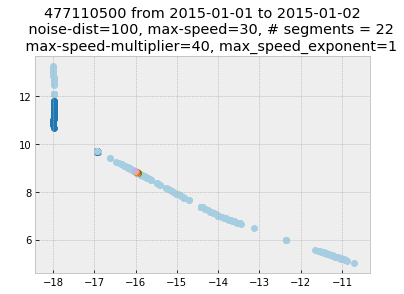

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=40 --max-speed-exponent=1    '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49.json' '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49-new.json'


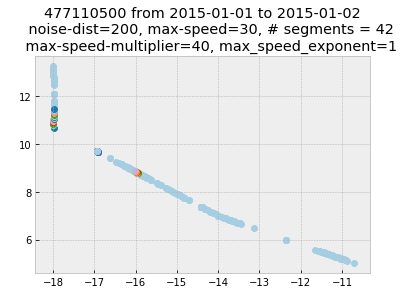

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=15 --max-speed-exponent=1.3    '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49.json' '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49-new.json'


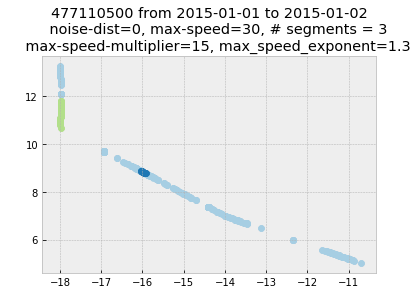

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=15 --max-speed-exponent=1.3    '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49.json' '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49-new.json'


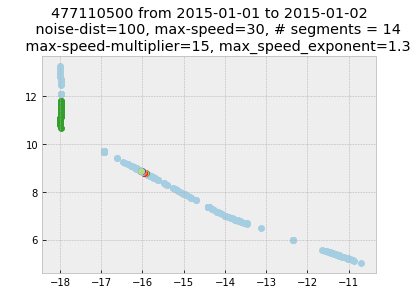

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=15 --max-speed-exponent=1.3    '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49.json' '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49-new.json'


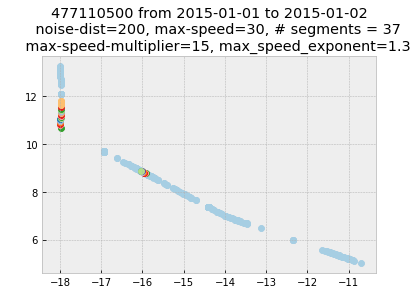

gpsdio segment --max-speed=30 --noise-dist=0      --max-speed-multiplier=1600 --max-speed-exponent=2    '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49.json' '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49-new.json'


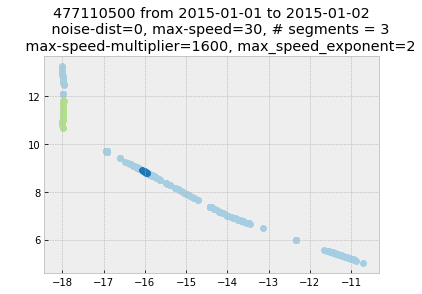

gpsdio segment --max-speed=30 --noise-dist=100      --max-speed-multiplier=1600 --max-speed-exponent=2    '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49.json' '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49-new.json'


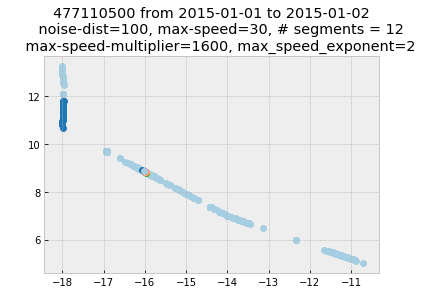

gpsdio segment --max-speed=30 --noise-dist=200      --max-speed-multiplier=1600 --max-speed-exponent=2    '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49.json' '477110500-2015-01-01 15:34:37-2015-01-02 23:23:49-new.json'


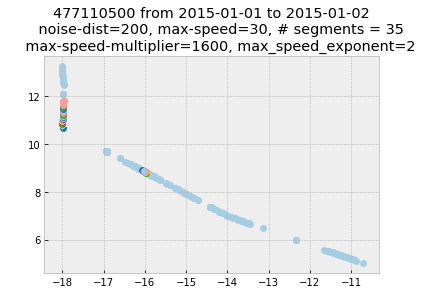

In [164]:
# let's see how it does on the spoofing vessels...
for i in range(10):
    row = df.iloc[i]
    start, end = get_timerange(row)
    mmsi = row.mmsi

    q = '''

    select mmsi, timestamp, lat, lon, speed from 
    table_date_range([pipeline_classify_p_p516_daily.], timestamp("{0}"), timestamp("{1}"))
    where mmsi = {2}
    and lat is not null and lon is not null
    order by timestamp
    '''.format(str(start), str(end), mmsi)

    dfv = pd.io.gbq.read_gbq(q, project_id='world-fishing-827',verbose=False)
    dfv.head()


    filename = "{0}-{1}-{2}.json".format(mmsi,str(start), str(end))
    with open(filename, 'w') as f:
        for idx, row in dfv.iterrows():
            row.timestamp = str(row.timestamp)
            row.to_json(f)
            f.write("\n")

    for k, i in zip([1,1,1.3,2],[24,40,15,1600]):
        map_segment(filename, max_speed=30, noise_dist=0,\
                        max_speed_exponent = k, max_speed_multiplier = i)
    
        map_segment(filename, max_speed=30, noise_dist=100,\
                    max_speed_exponent = k, max_speed_multiplier = i)
        
        map_segment(filename, max_speed=30, noise_dist=200,\
            max_speed_exponent = k, max_speed_multiplier = i)

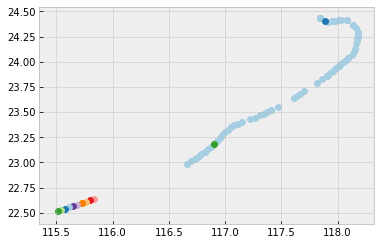

In [82]:
cols = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
for i, (x,y) in enumerate(zip(xx,yy)):
    plt.scatter(x,y, color=cols[i%len(cols)])


gpsdio segment --max-speed=30 --noise-dist=0 'temp.json' 'temp-new.json'


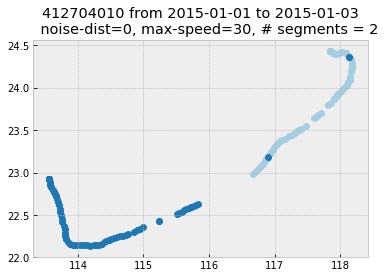

gpsdio segment --max-speed=30 --noise-dist=20 'temp.json' 'temp-new.json'


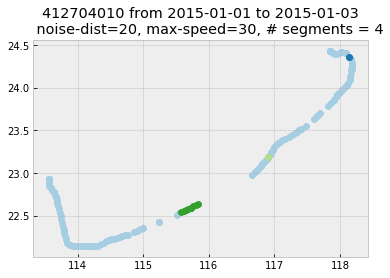

gpsdio segment --max-speed=30 --noise-dist=50 'temp.json' 'temp-new.json'


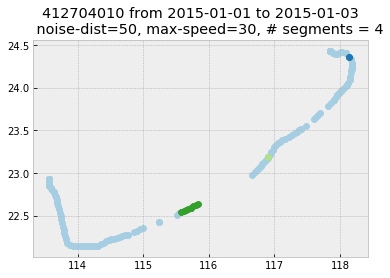

gpsdio segment --max-speed=30 --noise-dist=100 'temp.json' 'temp-new.json'


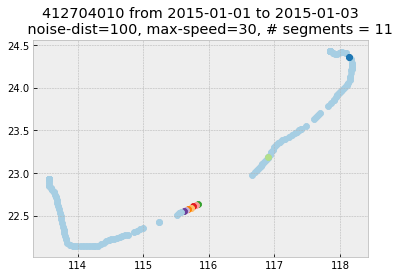

In [131]:
for i in [0,20,50,100]:
    x = map_segment('temp.json', i, 30)

In [116]:
# Does it work well with vessels that are spoofing legitimately?
# First step: identify some questionable segments

q = '''SELECT
  mmsi,
  a.seg_id seg_id,
  a.next_seg_id next_seg_id,
  avg_dist_nm,
  jumps,
  seg_point_count,
  next_seg_point_count,
  seg_first_timestamp,
  next_seg_first_timestamp, 
  seg_last_timestamp,
  next_seg_last_timestamp
FROM (
  SELECT
    mmsi,
    seg_id,
    next_seg_id,
    AVG(dist_nm) avg_dist_nm,
    COUNT(*) jumps
  FROM (
    SELECT
      *,
      dist_nm/tot_hours knots
    FROM (
      SELECT
        mmsi,
        (next_timestamp - timestamp)/3600000000 tot_hours,
        (ACOS(COS(RADIANS(90-lat)) *COS(RADIANS(90-next_lat)) +SIN(RADIANS(90-lat)) *SIN(RADIANS(90-next_lat)) * COS(RADIANS(lon-next_lon)))*6371000)/1000/1.852 dist_nm,
        seg_id,
        next_seg_id,
        timestamp,
        next_timestamp,
        lat,
        lon
      FROM (
        SELECT
          mmsi,
          seg_id,
          LEAD(timestamp,1) OVER (PARTITION BY mmsi ORDER BY timestamp) next_timestamp,
          LEAD(seg_id,1) OVER (PARTITION BY mmsi ORDER BY timestamp) next_seg_id,
          LEAD(timestamp,1) OVER (PARTITION BY seg_id ORDER BY timestamp) next_timestamp_seg,
          timestamp,
          lat,
          lon,
          LEAD(lat,1) OVER (PARTITION BY mmsi ORDER BY timestamp) next_lat,
          LEAD(lon,1) OVER (PARTITION BY mmsi ORDER BY timestamp) next_lon
        FROM
          [world-fishing-827:scratch_paul.pipe_segment_v0_9_alpha_2015_01]
        WHERE
          lat IS NOT NULL
          AND lon IS NOT NULL))
    WHERE
      tot_hours < 24)
  WHERE
    next_seg_id IS NOT NULL
  GROUP BY
    seg_id,
    next_seg_id,
    mmsi) a
INNER JOIN (
  SELECT
    x.seg_id seg_id,
    y.seg_id next_seg_id,
    x.point_count seg_point_count,
    y.point_count next_seg_point_count,
    x.first_timestamp seg_first_timestamp,
    y.first_timestamp next_seg_first_timestamp,
    x.last_timestamp seg_last_timestamp,
    y.last_timestamp next_seg_last_timestamp
  FROM
    [world-fishing-827:scratch_david_seg_analysis.segs_v0_9_alpha_2015_01] x
  LEFT JOIN
    [world-fishing-827:scratch_david_seg_analysis.segs_v0_9_alpha_2015_01] y
  ON
    x.mmsi = y.mmsi
  WHERE
    x.first_timestamp < y.last_timestamp
    AND x.last_timestamp > y.first_timestamp
    AND x.seg_id != y.seg_id
    -- and a.max_lat > b.min_lat and a.min_lat < b.max_lat
    -- and a.max_lon > b.min_lon and a.min_lon < b.min_lon
    ) b
ON
  a.seg_id = b.seg_id
  AND a.next_seg_id = b.next_seg_id
  where seg_point_count > 100
  and next_seg_point_count > 100
  and avg_dist_nm > 400
  limit 100'''

df = pd.io.gbq.read_gbq(q, project_id='world-fishing-827',verbose=False)
print len(df)
df.head()


100


mmsi                                 seg_id  \
0  416241500  416241500-2015-01-21T00:31:55.000000Z   
1  412470450  412470450-2015-01-26T12:37:49.000000Z   
2  319349000  319349000-2015-01-01T01:04:12.000000Z   
3  354292000  354292000-2015-01-04T10:18:03.000000Z   
4  555555555  555555555-2015-01-17T06:04:48.000000Z   

                             next_seg_id  avg_dist_nm  jumps  seg_point_count  \
0  416241500-2015-01-01T00:10:39.000000Z  3190.818029     91              233   
1  412470450-2015-01-18T09:30:18.000000Z   427.611063     22              381   
2  319349000-2015-01-01T00:32:59.000000Z  4049.267517     42              248   
3  354292000-2015-01-02T18:31:52.000000Z   925.622926     49              232   
4  555555555-2015-01-24T11:35:46.000000Z  4256.987871     25              464   

   next_seg_point_count seg_first_timestamp next_seg_first_timestamp  \
0                  3246 2015-01-21 00:31:55      2015-01-01 00:10:39   
1                   713 2015-01-26 12:37:49      2015-01-18 09:30:18   
2                   127 2015-01-01 01:04:12      2015-01-01 00:32:59   
3                   180 2015-01-04 10:18:03      2015-01-02 18:31:52   
4                   194 2015-01-17 06:04:48      2015-01-24 11:35:46   

   seg_last_timestamp next_seg_last_timestamp  
0 2015-01-23 03:04:15     2015-02-01 17:22:02  
1 2015-01-31 10:51:05     2015-01-28 17:36:41  
2 2015-01-12 16:49:13     2015-01-07 12:13:22  
3 2015-01-08 06:22:39     2015-01-10 09:46:49  
4 2015-01-29 19:11:15     2015-02-01 04:56:17

gpsdio segment --max-speed=30 --noise-dist=0 '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15.json' '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15-new.json'


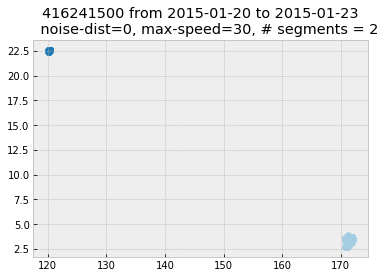

gpsdio segment --max-speed=30 --noise-dist=100 '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15.json' '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15-new.json'


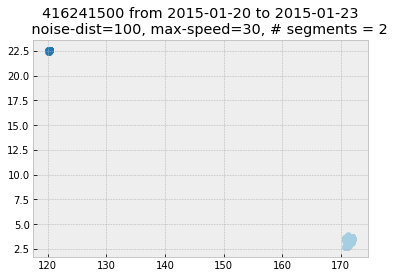

gpsdio segment --max-speed=30 --noise-dist=1000 '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15.json' '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15-new.json'


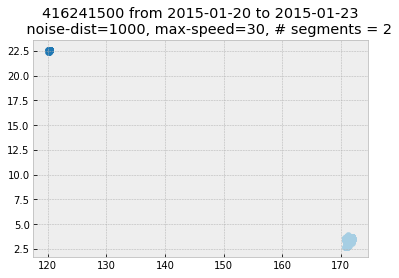

gpsdio segment --max-speed=30 --noise-dist=0 '412470450-2015-01-26 00:37:49-2015-01-29 05:36:41.json' '412470450-2015-01-26 00:37:49-2015-01-29 05:36:41-new.json'


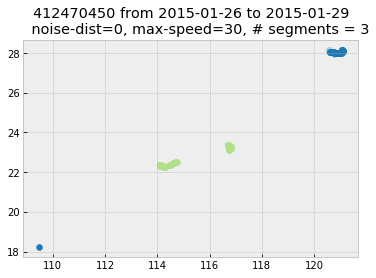

gpsdio segment --max-speed=30 --noise-dist=100 '412470450-2015-01-26 00:37:49-2015-01-29 05:36:41.json' '412470450-2015-01-26 00:37:49-2015-01-29 05:36:41-new.json'


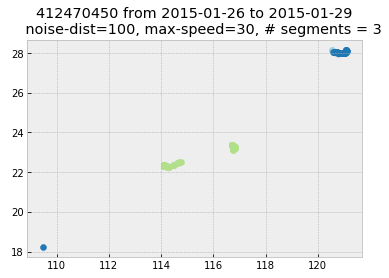

gpsdio segment --max-speed=30 --noise-dist=1000 '412470450-2015-01-26 00:37:49-2015-01-29 05:36:41.json' '412470450-2015-01-26 00:37:49-2015-01-29 05:36:41-new.json'


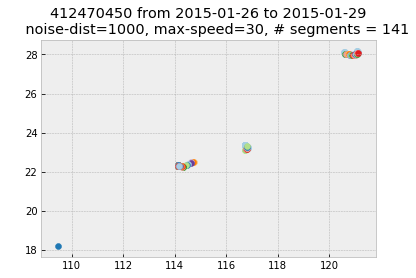

gpsdio segment --max-speed=30 --noise-dist=0 '319349000-2014-12-31 13:04:12-2015-01-08 00:13:22.json' '319349000-2014-12-31 13:04:12-2015-01-08 00:13:22-new.json'


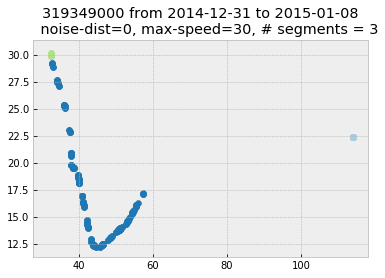

gpsdio segment --max-speed=30 --noise-dist=100 '319349000-2014-12-31 13:04:12-2015-01-08 00:13:22.json' '319349000-2014-12-31 13:04:12-2015-01-08 00:13:22-new.json'


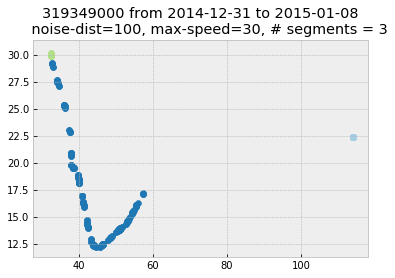

gpsdio segment --max-speed=30 --noise-dist=1000 '319349000-2014-12-31 13:04:12-2015-01-08 00:13:22.json' '319349000-2014-12-31 13:04:12-2015-01-08 00:13:22-new.json'


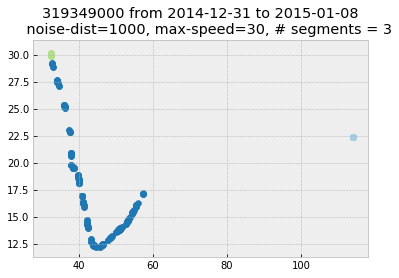

gpsdio segment --max-speed=30 --noise-dist=0 '354292000-2015-01-03 22:18:03-2015-01-08 18:22:39.json' '354292000-2015-01-03 22:18:03-2015-01-08 18:22:39-new.json'


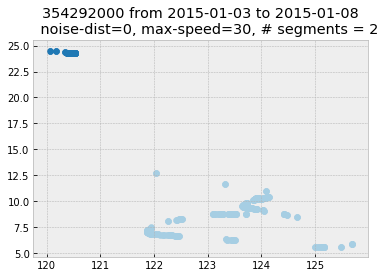

gpsdio segment --max-speed=30 --noise-dist=100 '354292000-2015-01-03 22:18:03-2015-01-08 18:22:39.json' '354292000-2015-01-03 22:18:03-2015-01-08 18:22:39-new.json'


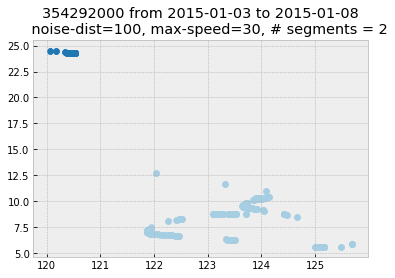

gpsdio segment --max-speed=30 --noise-dist=1000 '354292000-2015-01-03 22:18:03-2015-01-08 18:22:39.json' '354292000-2015-01-03 22:18:03-2015-01-08 18:22:39-new.json'


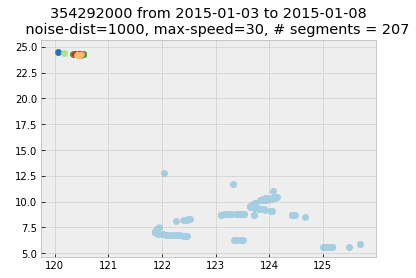

gpsdio segment --max-speed=30 --noise-dist=0 '555555555-2015-01-23 23:35:46-2015-01-30 07:11:15.json' '555555555-2015-01-23 23:35:46-2015-01-30 07:11:15-new.json'


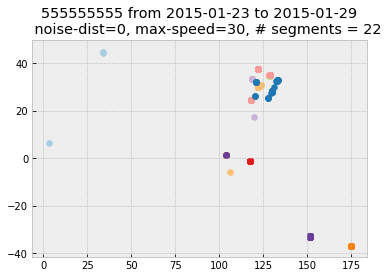

gpsdio segment --max-speed=30 --noise-dist=100 '555555555-2015-01-23 23:35:46-2015-01-30 07:11:15.json' '555555555-2015-01-23 23:35:46-2015-01-30 07:11:15-new.json'


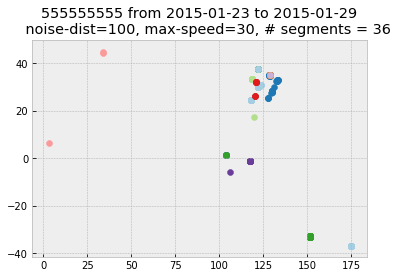

gpsdio segment --max-speed=30 --noise-dist=1000 '555555555-2015-01-23 23:35:46-2015-01-30 07:11:15.json' '555555555-2015-01-23 23:35:46-2015-01-30 07:11:15-new.json'


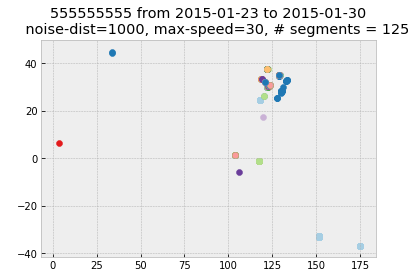

gpsdio segment --max-speed=30 --noise-dist=0 '440773000-2014-12-31 16:50:01-2015-02-02 08:26:02.json' '440773000-2014-12-31 16:50:01-2015-02-02 08:26:02-new.json'


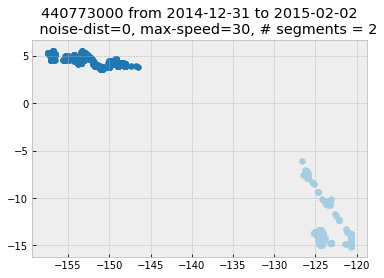

gpsdio segment --max-speed=30 --noise-dist=100 '440773000-2014-12-31 16:50:01-2015-02-02 08:26:02.json' '440773000-2014-12-31 16:50:01-2015-02-02 08:26:02-new.json'


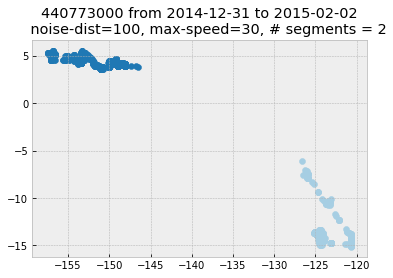

gpsdio segment --max-speed=30 --noise-dist=1000 '440773000-2014-12-31 16:50:01-2015-02-02 08:26:02.json' '440773000-2014-12-31 16:50:01-2015-02-02 08:26:02-new.json'


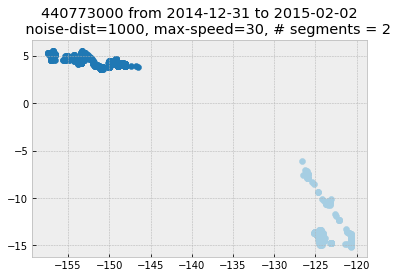

gpsdio segment --max-speed=30 --noise-dist=0 '412100000-2015-01-30 15:44:37-2015-02-02 11:51:57.json' '412100000-2015-01-30 15:44:37-2015-02-02 11:51:57-new.json'


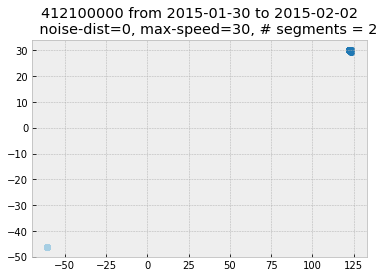

gpsdio segment --max-speed=30 --noise-dist=100 '412100000-2015-01-30 15:44:37-2015-02-02 11:51:57.json' '412100000-2015-01-30 15:44:37-2015-02-02 11:51:57-new.json'


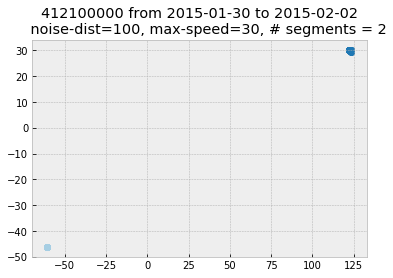

gpsdio segment --max-speed=30 --noise-dist=1000 '412100000-2015-01-30 15:44:37-2015-02-02 11:51:57.json' '412100000-2015-01-30 15:44:37-2015-02-02 11:51:57-new.json'


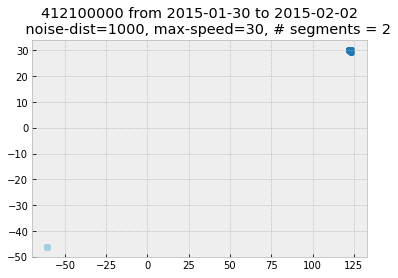

gpsdio segment --max-speed=30 --noise-dist=0 '419000000-2014-12-31 14:39:43-2015-01-14 16:56:45.json' '419000000-2014-12-31 14:39:43-2015-01-14 16:56:45-new.json'


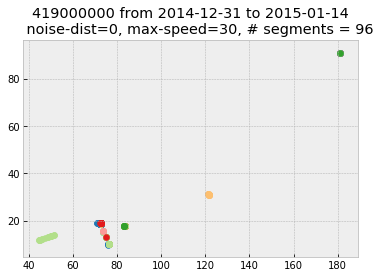

gpsdio segment --max-speed=30 --noise-dist=100 '419000000-2014-12-31 14:39:43-2015-01-14 16:56:45.json' '419000000-2014-12-31 14:39:43-2015-01-14 16:56:45-new.json'


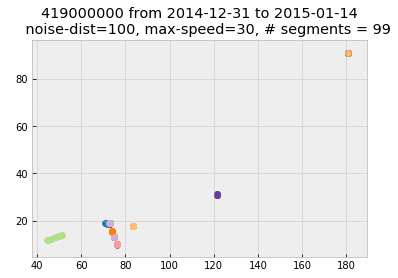

gpsdio segment --max-speed=30 --noise-dist=1000 '419000000-2014-12-31 14:39:43-2015-01-14 16:56:45.json' '419000000-2014-12-31 14:39:43-2015-01-14 16:56:45-new.json'


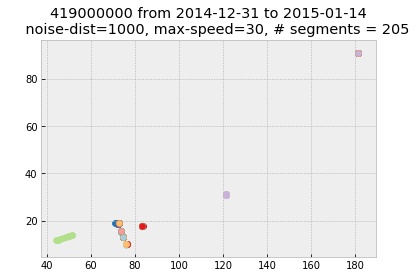

gpsdio segment --max-speed=30 --noise-dist=0 '525000000-2015-01-11 05:29:35-2015-02-02 05:34:45.json' '525000000-2015-01-11 05:29:35-2015-02-02 05:34:45-new.json'


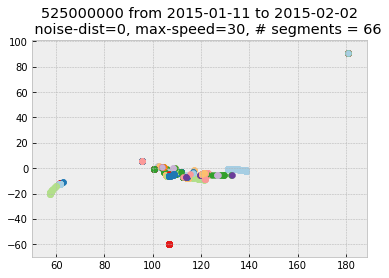

gpsdio segment --max-speed=30 --noise-dist=100 '525000000-2015-01-11 05:29:35-2015-02-02 05:34:45.json' '525000000-2015-01-11 05:29:35-2015-02-02 05:34:45-new.json'


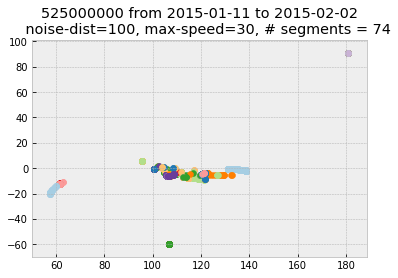

gpsdio segment --max-speed=30 --noise-dist=1000 '525000000-2015-01-11 05:29:35-2015-02-02 05:34:45.json' '525000000-2015-01-11 05:29:35-2015-02-02 05:34:45-new.json'


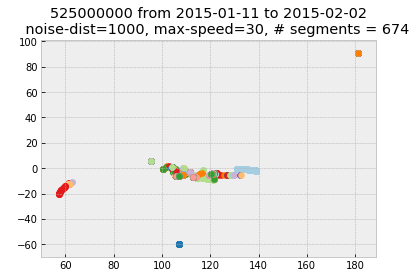

gpsdio segment --max-speed=30 --noise-dist=0 '525000000-2015-01-27 18:35:27-2015-02-01 01:21:03.json' '525000000-2015-01-27 18:35:27-2015-02-01 01:21:03-new.json'


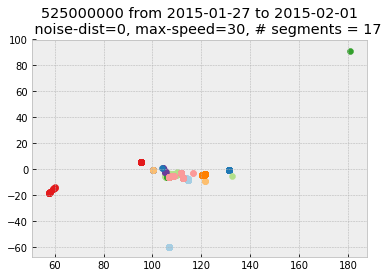

gpsdio segment --max-speed=30 --noise-dist=100 '525000000-2015-01-27 18:35:27-2015-02-01 01:21:03.json' '525000000-2015-01-27 18:35:27-2015-02-01 01:21:03-new.json'


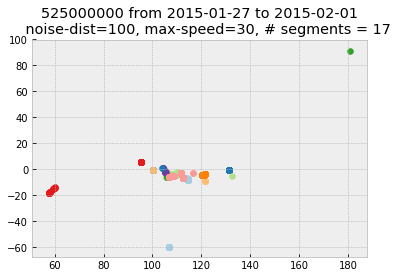

gpsdio segment --max-speed=30 --noise-dist=1000 '525000000-2015-01-27 18:35:27-2015-02-01 01:21:03.json' '525000000-2015-01-27 18:35:27-2015-02-01 01:21:03-new.json'


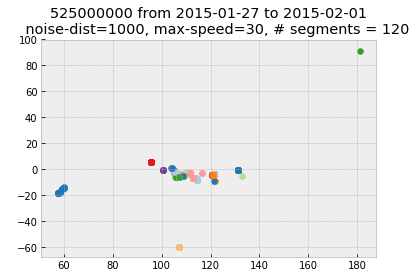

In [134]:
# let's see how it does on the spoofing vessels...
for i in range(10):
    row = df.iloc[i]
    start, end = get_timerange(row)
    mmsi = row.mmsi

    q = '''

    select mmsi, timestamp, lat, lon, speed from 
    table_date_range([pipeline_classify_p_p516_daily.], timestamp("{0}"), timestamp("{1}"))
    where mmsi = {2}
    and lat is not null and lon is not null
    order by timestamp
    '''.format(str(start), str(end), mmsi)

    dfv = pd.io.gbq.read_gbq(q, project_id='world-fishing-827',verbose=False)
    dfv.head()


    filename = "{0}-{1}-{2}.json".format(mmsi,str(start), str(end))
    with open(filename, 'w') as f:
        for idx, row in dfv.iterrows():
            row.timestamp = str(row.timestamp)
            row.to_json(f)
            f.write("\n")

    for i in [0,100,1000]:
        x = map_segment(filename, noise_dist=i, max_speed=30)

gpsdio segment --max-speed=30 --noise-dist=0 '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15.json' '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15-new.json'


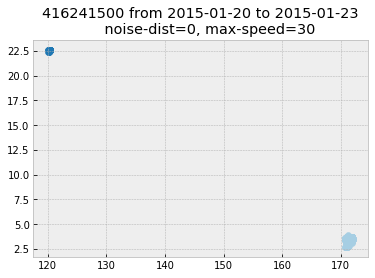

gpsdio segment --max-speed=30 --noise-dist=20 '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15.json' '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15-new.json'


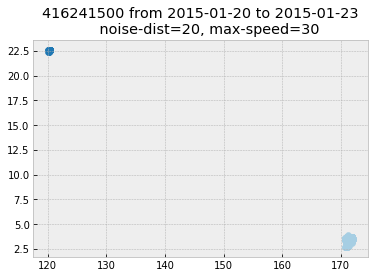

gpsdio segment --max-speed=30 --noise-dist=50 '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15.json' '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15-new.json'


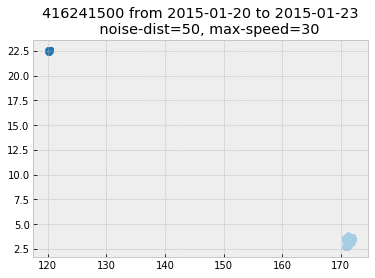

gpsdio segment --max-speed=30 --noise-dist=100 '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15.json' '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15-new.json'


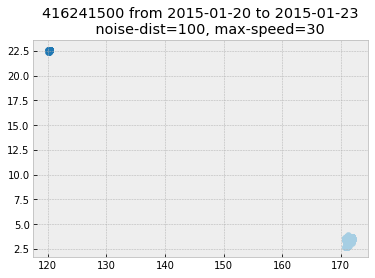

gpsdio segment --max-speed=30 --noise-dist=1000 '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15.json' '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15-new.json'


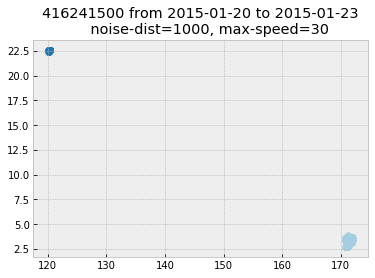

gpsdio segment --max-speed=30 --noise-dist=10000 '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15.json' '416241500-2015-01-20 12:31:55-2015-01-23 15:04:15-new.json'


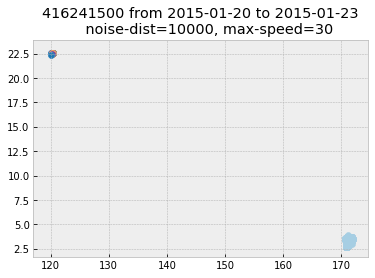